In [3]:
from PIL import ImageFile, Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import random
import time

In [9]:
pwd

'/home/basadi2/pocker'

In [4]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(14) 
data = pd.read_csv('data.csv')


Using 4 GPUs for training.
Best model saved at epoch 1 with Test R²: -0.0184
Epoch [1/100], Train Loss: 0.0882, Train R²: -0.4221, Train RMSE: 263.2251, Train MAE: 165.5172, Train MAPE: 37.85%, Test Loss: 0.0704, Test R²: -0.0184, Test RMSE: 219.7487, Test MAE: 132.4080, Test MAPE: 39.08%, Time: 00:00:12
Best model saved at epoch 2 with Test R²: 0.1425
Epoch [2/100], Train Loss: 0.0663, Train R²: -0.0741, Train RMSE: 228.7639, Train MAE: 148.4665, Train MAPE: 40.86%, Test Loss: 0.0505, Test R²: 0.1425, Test RMSE: 201.6395, Test MAE: 149.1773, Test MAPE: 56.60%, Time: 00:00:18
Best model saved at epoch 3 with Test R²: 0.2243
Epoch [3/100], Train Loss: 0.0589, Train R²: 0.0633, Train RMSE: 213.6340, Train MAE: 160.6124, Train MAPE: 55.12%, Test Loss: 0.0410, Test R²: 0.2243, Test RMSE: 191.7809, Test MAE: 154.7521, Test MAPE: 64.82%, Time: 00:00:23
Best model saved at epoch 4 with Test R²: 0.3134
Epoch [4/100], Train Loss: 0.0549, Train R²: 0.1331, Train RMSE: 205.5155, Train MAE: 151.58

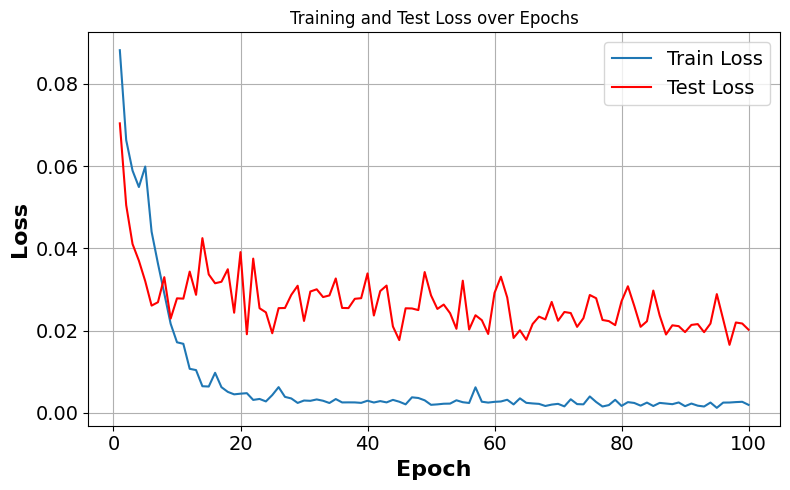

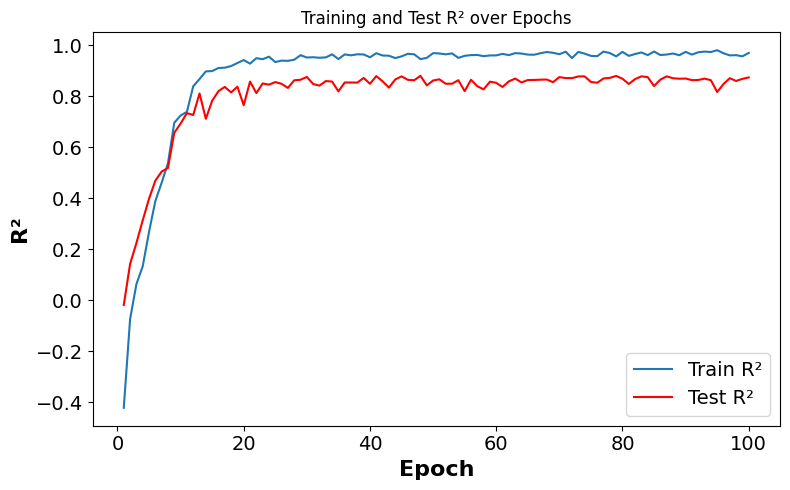

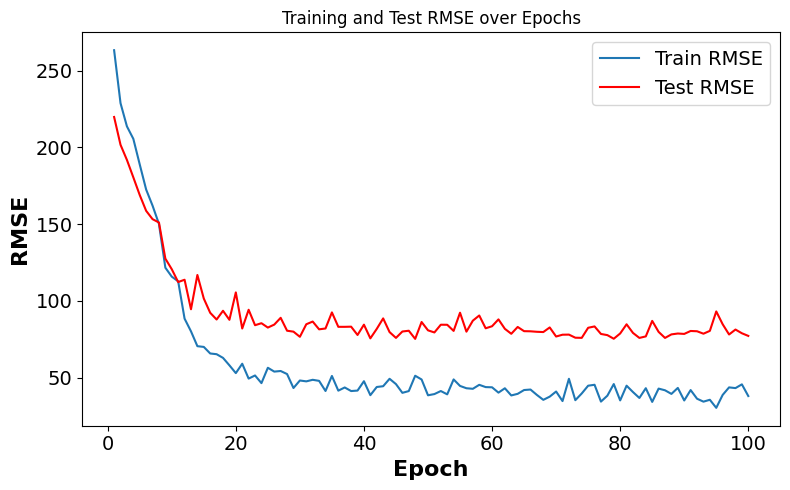

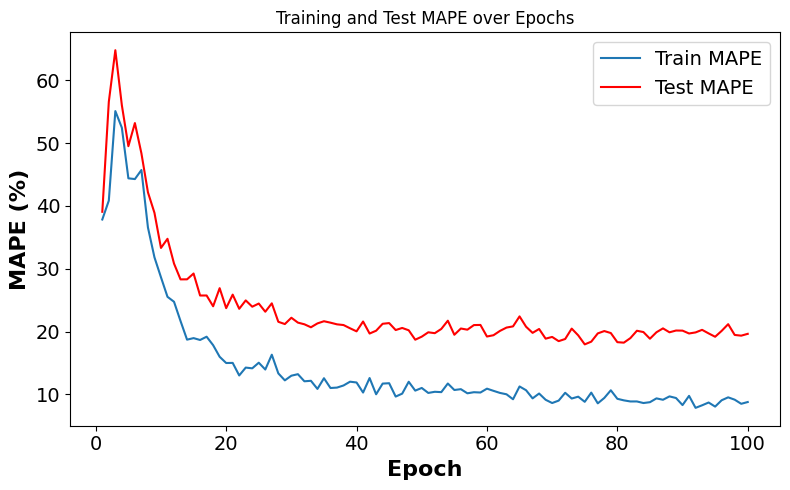

Final Training Loss: 0.0010, Final Training R²: 0.9875, Final Training RMSE: 24.7260, Final Training MAE: 19.2232, Final Training MAPE: 6.95%
Final Test Loss: 0.0250, Final Test R²: 0.8806, Final Test RMSE: 75.2456, Final Test MAE: 50.5485, Final Test MAPE: 20.20%


In [5]:
# ============================
# 0. Clear CUDA Cache convnext
# ============================
import torch
torch.cuda.empty_cache()

# ============================
# 1. Import Necessary Libraries
# ============================

import os
import time
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import timm

import matplotlib.pyplot as plt  # For plotting

# ============================
# 2. Define Data Transformations
# ============================

# Define transformations for training (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for augmentation
    transforms.RandomRotation(15),  # Random rotation for augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),# Random rotation for augmentation
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet values
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for testing (without augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 384x384
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet values
                         std=[0.229, 0.224, 0.225])
])

# ============================
# 3. Define the AsphaltDataset Class
# ============================

class AsphaltDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, scale_target=True, min_val=None, max_val=None):
        """
        Args:
            csv_file (str): Path to the CSV file with annotations.
            root_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            scale_target (bool): Whether to apply Min-Max scaling to the target.
            min_val (float, optional): Minimum value for scaling (used for test set).
            max_val (float, optional): Maximum value for scaling (used for test set).
        """
        self.data_frame = pd.read_csv(csv_file)  # Load CSV file with Ductility values
        self.root_dir = root_dir
        self.transform = transform
        self.scale_target = scale_target

        if self.scale_target:
            if min_val is None or max_val is None:
                self.min_val = self.data_frame['Ductility'].min()
                self.max_val = self.data_frame['Ductility'].max()
            else:
                self.min_val = min_val
                self.max_val = max_val

            # Avoid division by zero
            if self.max_val - self.min_val != 0:
                self.data_frame['Ductility'] = (self.data_frame['Ductility'] - self.min_val) / (self.max_val - self.min_val)
            else:
                self.data_frame['Ductility'] = 0.0  # If all values are the same

    def __len__(self):
        return len(self.data_frame)

    def find_image(self, base_name, suffix):
        """Try to find the image with multiple possible extensions."""
        extensions = ['png', 'jpg', 'jpeg']  # List of supported extensions
        for ext in extensions:
            img_path = os.path.join(self.root_dir, f"{base_name}-{suffix}.{ext}")
            if os.path.exists(img_path):
                return img_path
        return None  # If no file found

    def __getitem__(self, idx):
        base_name = str(self.data_frame.iloc[idx, 0]).strip()  # Ensure base_name is string and strip whitespace

        # Check for both bottom and top images with possible extensions
        img_name_bottom = self.find_image(base_name, 'B')
        img_name_top = self.find_image(base_name, 'T')

        if img_name_bottom is None or img_name_top is None:
            print(f"Warning: Missing image(s) for {base_name}, skipping.")
            # Recursively try the next index (with a limit to prevent infinite recursion)
            next_idx = (idx + 1) % len(self.data_frame)
            if next_idx == idx:
                raise RuntimeError(f"No valid images found in the dataset.")
            return self.__getitem__(next_idx)

        # Load both bottom and top images
        try:
            image_bottom = Image.open(img_name_bottom).convert('RGB')
            image_top = Image.open(img_name_top).convert('RGB')
        except Exception as e:
            print(f"Error loading images for {base_name}: {e}")
            # Recursively try the next index
            next_idx = (idx + 1) % len(self.data_frame)
            if next_idx == idx:
                raise RuntimeError(f"No valid images found in the dataset.")
            return self.__getitem__(next_idx)

        # Apply transformations if specified
        if self.transform:
            image_bottom = self.transform(image_bottom)
            image_top = self.transform(image_top)

        # Get the target value (Ductility)
        ductility_value = float(self.data_frame.iloc[idx, 1])

        return image_bottom, image_top, torch.tensor(ductility_value, dtype=torch.float32)

    def reverse_scaling(self, value):
        """Reverse the Min-Max scaling to get the original Ductility value."""
        return value * (self.max_val - self.min_val) + self.min_val

# ============================
# 4. Define the AsphaltNet Model
# ============================

class AsphaltNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AsphaltNet, self).__init__()
        # Feature extractor using Swin Transformer (smaller variant)
        self.feature_extractor = timm.create_model('convnext_large.fb_in22k', pretrained=True, num_classes=0)
        
        # Regressor to predict Ductility from concatenated features
        self.regressor = nn.Sequential(
            nn.Linear(self.feature_extractor.num_features * 2, 512),  
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x_bottom, x_top):
        # Extract features for both bottom and top images
        features_bottom = self.feature_extractor(x_bottom)
        features_top = self.feature_extractor(x_top)

        # Concatenate features
        features = torch.cat((features_bottom, features_top), dim=1)

        # Pass concatenated features through the regressor
        output = self.regressor(features)

        # Ensure output has shape [batch_size, 1]
        return output.view(-1, 1)

# ============================
# 5. Define Evaluation Metrics
# ============================

def calculate_r2(targets, outputs):
    ss_res = np.sum((targets - outputs) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_rmse(targets, outputs):
    return np.sqrt(np.mean((targets - outputs) ** 2))

def calculate_mae(targets, outputs):
    return np.mean(np.abs(targets - outputs))

def calculate_mape(targets, outputs):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Args:
        targets (np.ndarray): Ground truth target values.
        outputs (np.ndarray): Predicted values.

    Returns:
        float: MAPE value in percentage.
    """
    epsilon = 1e-10  # Small value to avoid division by zero
    return np.mean(np.abs((targets - outputs) / (targets + epsilon))) * 100

# ============================
# 6. Define Evaluation Function
# ============================

def evaluate_model(model, data_loader, criterion, dataset=None):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for bottom_images, top_images, targets in data_loader:
            bottom_images, top_images, targets = bottom_images.to(device), top_images.to(device), targets.to(device)

            outputs = model(bottom_images, top_images)
            
            # Ensure outputs and targets are correctly shaped
            outputs = outputs.view(-1)  # Flatten the outputs
            targets = targets.view(-1)  # Flatten the targets if necessary

            loss = criterion(outputs, targets)
            running_loss += loss.item()

            all_targets.extend(targets.detach().cpu().numpy())
            all_outputs.extend(outputs.detach().cpu().numpy())

    all_targets = np.array(all_targets)
    all_outputs = np.array(all_outputs)

    if dataset and dataset.scale_target:
        # Reverse scale the targets and outputs
        all_targets = dataset.reverse_scaling(all_targets)
        all_outputs = dataset.reverse_scaling(all_outputs)

    # Calculate metrics manually
    r2 = calculate_r2(all_targets, all_outputs)
    rmse = calculate_rmse(all_targets, all_outputs)
    mae = calculate_mae(all_targets, all_outputs)
    mape = calculate_mape(all_targets, all_outputs)  # Calculate MAPE

    avg_loss = running_loss / len(data_loader)

    return avg_loss, r2, rmse, mae, mape, all_targets, all_outputs

# ============================
# 7. Define Helper Function for Time Formatting
# ============================

def seconds_to_hms(seconds):
    """Converts seconds to a hh:mm:ss format string."""
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"

# ============================
# 8. Define Training Function
# ============================

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, train_dataset, test_dataset, num_epochs=50, save_path='asphaltnet_model'):
    """
    Trains the model and saves the best model based on higher Test R².
    Incorporates MAPE as an additional metric.
    
    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for test data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        scheduler (optim.lr_scheduler): Learning rate scheduler.
        train_dataset (AsphaltDataset): Training dataset instance.
        test_dataset (AsphaltDataset): Test dataset instance.
        num_epochs (int): Number of epochs to train.
        save_path (str): Base path to save the model.
    """
    models_dir = 'convenextPT'
    os.makedirs(models_dir, exist_ok=True)  # Create the directory if it doesn't exist
    start_time = time.time()  # Start timing

    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_r2s = []
    test_r2s = []
    train_rmses = []
    test_rmses = []
    train_maes = []
    test_maes = []
    train_mapes = []  # Added for MAPE
    test_mapes = []   # Added for MAPE

    best_test_r2 = -np.inf  # Initialize best R²
    best_model_path = os.path.join(models_dir, f"{save_path}_best.pth")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_train_targets = []
        all_train_outputs = []

        # Training phase
        for bottom_images, top_images, targets in train_loader:
            bottom_images, top_images, targets = bottom_images.to(device), top_images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(bottom_images, top_images)

            # Ensure the output and targets are the same shape
            outputs = outputs.view(-1)  # Flatten the outputs
            targets = targets.view(-1)  # Flatten the targets if necessary

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            all_train_targets.extend(targets.detach().cpu().numpy())
            all_train_outputs.extend(outputs.detach().cpu().numpy())
        
        # Convert lists to numpy arrays for calculation
        all_train_targets = np.array(all_train_targets)
        all_train_outputs = np.array(all_train_outputs)

        if train_dataset.scale_target:
            # Reverse scale the targets and outputs
            all_train_targets = train_dataset.reverse_scaling(all_train_targets)
            all_train_outputs = train_dataset.reverse_scaling(all_train_outputs)

        # Calculate R², RMSE, MAE, and MAPE for training manually
        train_r2 = calculate_r2(all_train_targets, all_train_outputs)
        train_rmse = calculate_rmse(all_train_targets, all_train_outputs)
        train_mae = calculate_mae(all_train_targets, all_train_outputs)
        train_mape = calculate_mape(all_train_targets, all_train_outputs)  # Calculate MAPE

        # Calculate average training loss
        train_loss = running_loss / len(train_loader)

        # Testing phase: evaluate on test set
        test_loss, test_r2, test_rmse, test_mae, test_mape, _, _ = evaluate_model(model, test_loader, criterion, dataset=test_dataset)

        # Step the scheduler based on Test Loss
        scheduler.step(test_loss)

        # Save metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_r2s.append(train_r2)
        test_r2s.append(test_r2)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        train_maes.append(train_mae)
        test_maes.append(test_mae)
        train_mapes.append(train_mape)  # Append training MAPE
        test_mapes.append(test_mape)    # Append testing MAPE

        # Check if this epoch has the best Test R²
        if test_r2 > best_test_r2:
            best_test_r2 = test_r2
            # Save the underlying model's state_dict without 'module.' prefix
            if isinstance(model, nn.DataParallel):
                torch.save(model.module.state_dict(), best_model_path)
            else:
                torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1} with Test R²: {test_r2:.4f}")

        # Convert epoch_time to hh:mm:ss
        epoch_time = time.time() - start_time
        formatted_time = seconds_to_hms(epoch_time)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train R²: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train MAPE: {train_mape:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MAPE: {test_mape:.2f}%, "
              f"Time: {formatted_time}")

    print('Training complete')

    # ============================
    # 9. Plot Metrics After Training
    # ============================

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', color='red')
    plt.xlabel('Epoch', fontsize=16, fontweight='bold')
    plt.ylabel('Loss', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Training and Test Loss over Epochs')
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'loss_curve.png'))
    plt.show()

    # Plot R²
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_r2s, label='Train R²')
    plt.plot(range(1, num_epochs+1), test_r2s, label='Test R²', color='red')
    plt.xlabel('Epoch', fontsize=16, fontweight='bold')
    plt.ylabel('R²', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Training and Test R² over Epochs')
    plt.legend(fontsize=14)
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'r2_curve.png'))
    plt.show()

    # Plot RMSE
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_rmses, label='Train RMSE')
    plt.plot(range(1, num_epochs+1), test_rmses, label='Test RMSE', color='red')
    plt.xlabel('Epoch', fontsize=16, fontweight='bold')
    plt.ylabel('RMSE', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Training and Test RMSE over Epochs')
    plt.legend(fontsize=14)
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'rmse_curve.png'))
    plt.show()

    # Plot MAPE
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_mapes, label='Train MAPE')
    plt.plot(range(1, num_epochs+1), test_mapes, label='Test MAPE', color='red')
    plt.xlabel('Epoch', fontsize=16, fontweight='bold')
    plt.ylabel('MAPE (%)', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Training and Test MAPE over Epochs')
    plt.legend(fontsize=14)
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'mape_curve.png'))
    plt.show()

    # ============================
    # 10. Measured vs Predicted Plots
    # ============================

    # Load the best model
    best_model_path = os.path.join(models_dir, f"{save_path}_best.pth")
    model = AsphaltNet(num_classes=1)
    model.load_state_dict(torch.load(best_model_path))
    
    # Wrap with DataParallel if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)
    model.eval()

    # Evaluate on training set
    train_loss, train_r2, train_rmse, train_mae, train_mape, train_targets, train_outputs = evaluate_model(model, train_loader, criterion, dataset=train_dataset)

    # Evaluate on test set
    test_loss, test_r2, test_rmse, test_mae, test_mape, test_targets, test_outputs = evaluate_model(model, test_loader, criterion, dataset=test_dataset)

    # ============================
    # 11. Final Evaluation on Best Model
    # ============================

    print(f"Final Training Loss: {train_loss:.4f}, Final Training R²: {train_r2:.4f}, Final Training RMSE: {train_rmse:.4f}, Final Training MAE: {train_mae:.4f}, Final Training MAPE: {train_mape:.2f}%")
    print(f"Final Test Loss: {test_loss:.4f}, Final Test R²: {test_r2:.4f}, Final Test RMSE: {test_rmse:.4f}, Final Test MAE: {test_mae:.4f}, Final Test MAPE: {test_mape:.2f}%")

# ============================
# 9. Initialize Dataset and DataLoader
# ============================

# Paths to your CSV files and image directories
train_csv = 'train.csv'       # Replace with your training CSV file path
test_csv = 'test.csv'         # Replace with your testing CSV file path
train_images_dir = 'Training_images'  # Replace with your training images directory
test_images_dir = 'Testing_images'    # Replace with your testing images directory

# Initialize the training dataset to compute min and max
train_dataset = AsphaltDataset(
    csv_file=train_csv,
    root_dir=train_images_dir,
    transform=train_transform,
    scale_target=True
)

# Retrieve min and max from the training dataset
train_min = train_dataset.min_val
train_max = train_dataset.max_val

# Create the test dataset using the same min and max
test_dataset = AsphaltDataset(
    csv_file=test_csv,
    root_dir=test_images_dir,
    transform=test_transform,
    scale_target=True,
    min_val=train_min,
    max_val=train_max
)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# ============================
# 10. Initialize Model, Loss, Optimizer, and Scheduler
# ============================

# Initialize the model
model = AsphaltNet(num_classes=1)

# Check for GPU availability and utilize multiple GPUs if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_count = torch.cuda.device_count()
    if gpu_count > 1:
        model = nn.DataParallel(model)
        print(f"Using {gpu_count} GPUs for training.")
    else:
        print("Using a single GPU for training.")
else:
    device = torch.device("cpu")
    print("Using CPU for training.")

model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

# Define a Learning Rate Scheduler (optional but recommended)
# This scheduler reduces the learning rate by a factor of 0.1 if the Test Loss doesn't improve for 5 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, verbose=True)

# ============================
# 11. Start Training and Plotting
# ============================

# Call the train_model function to start training and plotting

train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    num_epochs=100, 
    save_path='asphaltnet_model' 
)

Using 4 GPUs for training.
Best model saved at epoch 1 with Test R²: -0.0638
Epoch [1/100], Train Loss: 0.0989, Train R²: -0.4256, Train RMSE: 263.5462, Train MAE: 179.3597, Train MAPE: 48.78%, Test Loss: 0.0551, Test R²: -0.0638, Test RMSE: 224.5863, Test MAE: 200.8288, Test MAPE: 92.56%, Time: 00:00:05
Epoch [2/100], Train Loss: 0.0680, Train R²: -0.0578, Train RMSE: 227.0202, Train MAE: 187.2301, Train MAPE: 72.05%, Test Loss: 0.0568, Test R²: -0.1680, Test RMSE: 235.3361, Test MAE: 218.4558, Test MAPE: 106.74%, Time: 00:00:10
Epoch [3/100], Train Loss: 0.0686, Train R²: -0.0655, Train RMSE: 227.8436, Train MAE: 190.7672, Train MAPE: 75.17%, Test Loss: 0.0551, Test R²: -0.0805, Test RMSE: 226.3413, Test MAE: 204.4078, Test MAPE: 95.42%, Time: 00:00:15
Best model saved at epoch 4 with Test R²: 0.0005
Epoch [4/100], Train Loss: 0.0738, Train R²: -0.1415, Train RMSE: 235.8294, Train MAE: 185.5675, Train MAPE: 66.92%, Test Loss: 0.0579, Test R²: 0.0005, Test RMSE: 217.6969, Test MAE: 17

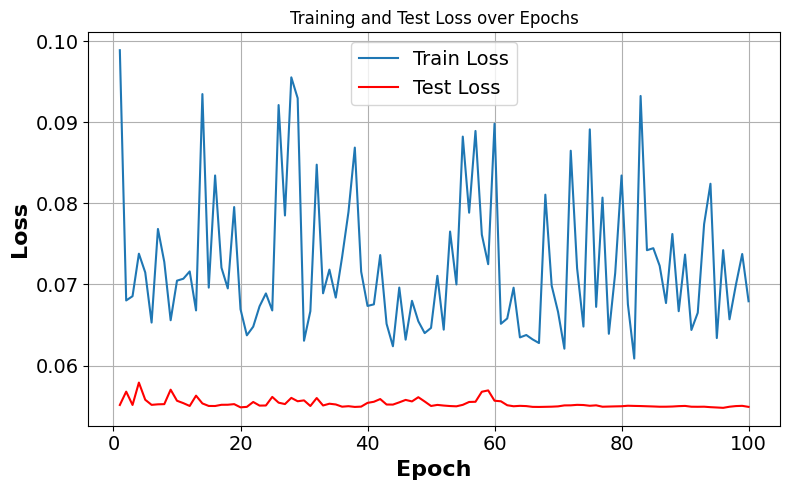

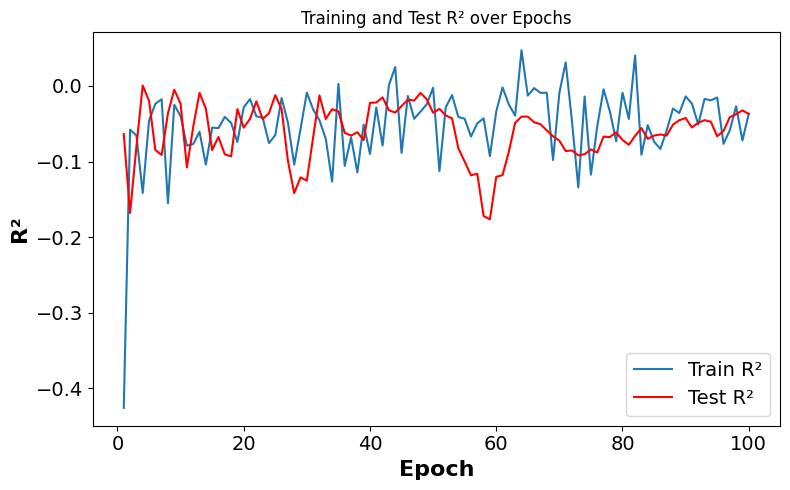

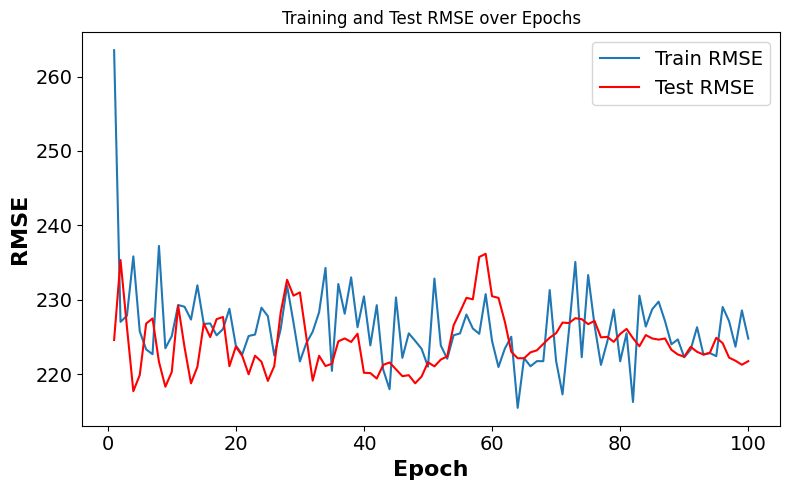

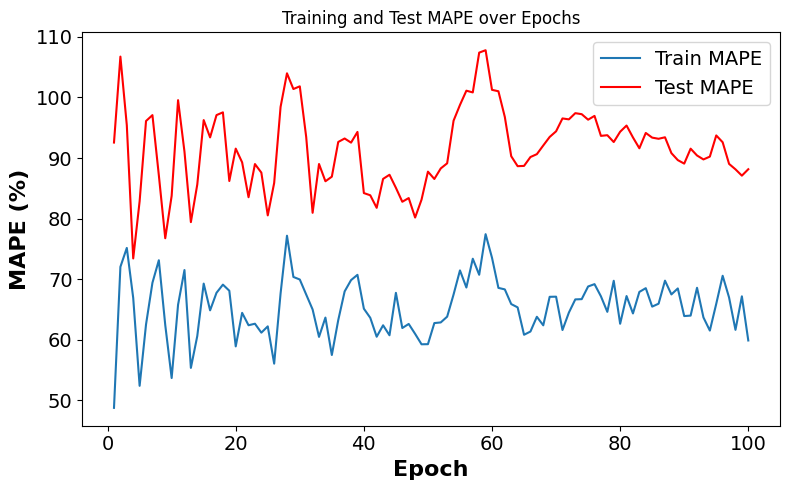

Final Training Loss: 0.0656, Final Training R²: -0.0134, Final Training RMSE: 222.2059, Final Training MAE: 168.4943, Final Training MAPE: 57.55%
Final Test Loss: 0.0579, Final Test R²: 0.0005, Final Test RMSE: 217.6969, Final Test MAE: 177.0687, Final Test MAPE: 73.43%


In [8]:
# No PT

class AsphaltNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AsphaltNet, self).__init__()
        self.feature_extractor = timm.create_model('convnext_large.fb_in22k', pretrained=False, num_classes=0) # pretrained=False or True?
        
        # Regressor to predict Ductility from concatenated features
        self.regressor = nn.Sequential(
            nn.Linear(self.feature_extractor.num_features * 2, 512),  
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x_bottom, x_top):
        # Extract features for both bottom and top images
        features_bottom = self.feature_extractor(x_bottom)
        features_top = self.feature_extractor(x_top)

        # Concatenate features
        features = torch.cat((features_bottom, features_top), dim=1)

        # Pass concatenated features through the regressor
        output = self.regressor(features)

        # Ensure output has shape [batch_size, 1]
        return output.view(-1, 1)

# ============================
# 5. Define Evaluation Metrics
# ============================

def calculate_r2(targets, outputs):
    ss_res = np.sum((targets - outputs) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_rmse(targets, outputs):
    return np.sqrt(np.mean((targets - outputs) ** 2))

def calculate_mae(targets, outputs):
    return np.mean(np.abs(targets - outputs))

def calculate_mape(targets, outputs):
    """
    Calculate Mean Absolute Percentage Error (MAPE).

    Args:
        targets (np.ndarray): Ground truth target values.
        outputs (np.ndarray): Predicted values.

    Returns:
        float: MAPE value in percentage.
    """
    epsilon = 1e-10  # Small value to avoid division by zero
    return np.mean(np.abs((targets - outputs) / (targets + epsilon))) * 100

# ============================
# 6. Define Evaluation Function
# ============================

def evaluate_model(model, data_loader, criterion, dataset=None):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_outputs = []

    with torch.no_grad():
        for bottom_images, top_images, targets in data_loader:
            bottom_images, top_images, targets = bottom_images.to(device), top_images.to(device), targets.to(device)

            outputs = model(bottom_images, top_images)
            
            # Ensure outputs and targets are correctly shaped
            outputs = outputs.view(-1)  # Flatten the outputs
            targets = targets.view(-1)  # Flatten the targets if necessary

            loss = criterion(outputs, targets)
            running_loss += loss.item()

            all_targets.extend(targets.detach().cpu().numpy())
            all_outputs.extend(outputs.detach().cpu().numpy())

    all_targets = np.array(all_targets)
    all_outputs = np.array(all_outputs)

    if dataset and dataset.scale_target:
        # Reverse scale the targets and outputs
        all_targets = dataset.reverse_scaling(all_targets)
        all_outputs = dataset.reverse_scaling(all_outputs)

    # Calculate metrics manually
    r2 = calculate_r2(all_targets, all_outputs)
    rmse = calculate_rmse(all_targets, all_outputs)
    mae = calculate_mae(all_targets, all_outputs)
    mape = calculate_mape(all_targets, all_outputs)  # Calculate MAPE

    avg_loss = running_loss / len(data_loader)

    return avg_loss, r2, rmse, mae, mape, all_targets, all_outputs

# ============================
# 7. Define Helper Function for Time Formatting
# ============================

def seconds_to_hms(seconds):
    """Converts seconds to a hh:mm:ss format string."""
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"

# ============================
# 8. Define Training Function
# ============================

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, train_dataset, test_dataset, num_epochs=50, save_path='asphaltnet_model'):
    """
    Trains the model and saves the best model based on higher Test R².
    Incorporates MAPE as an additional metric.
    
    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for test data.
        criterion (nn.Module): Loss function.
        optimizer (optim.Optimizer): Optimizer.
        scheduler (optim.lr_scheduler): Learning rate scheduler.
        train_dataset (AsphaltDataset): Training dataset instance.
        test_dataset (AsphaltDataset): Test dataset instance.
        num_epochs (int): Number of epochs to train.
        save_path (str): Base path to save the model.
    """
    models_dir = 'efficientnet_b1.ft_in1k'
    os.makedirs(models_dir, exist_ok=True)  # Create the directory if it doesn't exist
    start_time = time.time()  # Start timing

    # Lists to store metrics
    train_losses = []
    test_losses = []
    train_r2s = []
    test_r2s = []
    train_rmses = []
    test_rmses = []
    train_maes = []
    test_maes = []
    train_mapes = []  # Added for MAPE
    test_mapes = []   # Added for MAPE

    best_test_r2 = -np.inf  # Initialize best R²
    best_model_path = os.path.join(models_dir, f"{save_path}_best.pth")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_train_targets = []
        all_train_outputs = []

        # Training phase
        for bottom_images, top_images, targets in train_loader:
            bottom_images, top_images, targets = bottom_images.to(device), top_images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(bottom_images, top_images)

            # Ensure the output and targets are the same shape
            outputs = outputs.view(-1)  # Flatten the outputs
            targets = targets.view(-1)  # Flatten the targets if necessary

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            all_train_targets.extend(targets.detach().cpu().numpy())
            all_train_outputs.extend(outputs.detach().cpu().numpy())
        
        # Convert lists to numpy arrays for calculation
        all_train_targets = np.array(all_train_targets)
        all_train_outputs = np.array(all_train_outputs)

        if train_dataset.scale_target:
            # Reverse scale the targets and outputs
            all_train_targets = train_dataset.reverse_scaling(all_train_targets)
            all_train_outputs = train_dataset.reverse_scaling(all_train_outputs)

        # Calculate R², RMSE, MAE, and MAPE for training manually
        train_r2 = calculate_r2(all_train_targets, all_train_outputs)
        train_rmse = calculate_rmse(all_train_targets, all_train_outputs)
        train_mae = calculate_mae(all_train_targets, all_train_outputs)
        train_mape = calculate_mape(all_train_targets, all_train_outputs)  # Calculate MAPE

        # Calculate average training loss
        train_loss = running_loss / len(train_loader)

        # Testing phase: evaluate on test set
        test_loss, test_r2, test_rmse, test_mae, test_mape, _, _ = evaluate_model(model, test_loader, criterion, dataset=test_dataset)

        # Step the scheduler based on Test Loss
        scheduler.step(test_loss)

        # Save metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_r2s.append(train_r2)
        test_r2s.append(test_r2)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        train_maes.append(train_mae)
        test_maes.append(test_mae)
        train_mapes.append(train_mape)  # Append training MAPE
        test_mapes.append(test_mape)    # Append testing MAPE

        # Check if this epoch has the best Test R²
        if test_r2 > best_test_r2:
            best_test_r2 = test_r2
            # Save the underlying model's state_dict without 'module.' prefix
            if isinstance(model, nn.DataParallel):
                torch.save(model.module.state_dict(), best_model_path)
            else:
                torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at epoch {epoch+1} with Test R²: {test_r2:.4f}")

        # Convert epoch_time to hh:mm:ss
        epoch_time = time.time() - start_time
        formatted_time = seconds_to_hms(epoch_time)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train R²: {train_r2:.4f}, Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}, Train MAPE: {train_mape:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test R²: {test_r2:.4f}, Test RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}, Test MAPE: {test_mape:.2f}%, "
              f"Time: {formatted_time}")

    print('Training complete')

    # ============================
    # 9. Plot Metrics After Training
    # ============================

    # Plot Loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss', color='red')
    plt.xlabel('Epoch', fontsize=16, fontweight='bold')
    plt.ylabel('Loss', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Training and Test Loss over Epochs')
    plt.legend(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'loss_curve.png'))
    plt.show()

    # Plot R²
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_r2s, label='Train R²')
    plt.plot(range(1, num_epochs+1), test_r2s, label='Test R²', color='red')
    plt.xlabel('Epoch', fontsize=16, fontweight='bold')
    plt.ylabel('R²', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Training and Test R² over Epochs')
    plt.legend(fontsize=14)
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'r2_curve.png'))
    plt.show()

    # Plot RMSE
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_rmses, label='Train RMSE')
    plt.plot(range(1, num_epochs+1), test_rmses, label='Test RMSE', color='red')
    plt.xlabel('Epoch', fontsize=16, fontweight='bold')
    plt.ylabel('RMSE', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Training and Test RMSE over Epochs')
    plt.legend(fontsize=14)
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'rmse_curve.png'))
    plt.show()

    # Plot MAPE
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_mapes, label='Train MAPE')
    plt.plot(range(1, num_epochs+1), test_mapes, label='Test MAPE', color='red')
    plt.xlabel('Epoch', fontsize=16, fontweight='bold')
    plt.ylabel('MAPE (%)', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Training and Test MAPE over Epochs')
    plt.legend(fontsize=14)
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(models_dir, 'mape_curve.png'))
    plt.show()

    # ============================
    # 10. Measured vs Predicted Plots
    # ============================

    # Load the best model
    best_model_path = os.path.join(models_dir, f"{save_path}_best.pth")
    model = AsphaltNet(num_classes=1)
    model.load_state_dict(torch.load(best_model_path))
    
    # Wrap with DataParallel if multiple GPUs are available
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    model.to(device)
    model.eval()

    # Evaluate on training set
    train_loss, train_r2, train_rmse, train_mae, train_mape, train_targets, train_outputs = evaluate_model(model, train_loader, criterion, dataset=train_dataset)

    # Evaluate on test set
    test_loss, test_r2, test_rmse, test_mae, test_mape, test_targets, test_outputs = evaluate_model(model, test_loader, criterion, dataset=test_dataset)

    # ============================
    # 11. Final Evaluation on Best Model
    # ============================

    print(f"Final Training Loss: {train_loss:.4f}, Final Training R²: {train_r2:.4f}, Final Training RMSE: {train_rmse:.4f}, Final Training MAE: {train_mae:.4f}, Final Training MAPE: {train_mape:.2f}%")
    print(f"Final Test Loss: {test_loss:.4f}, Final Test R²: {test_r2:.4f}, Final Test RMSE: {test_rmse:.4f}, Final Test MAE: {test_mae:.4f}, Final Test MAPE: {test_mape:.2f}%")

# ============================
# 9. Initialize Dataset and DataLoader
# ============================

# Paths to your CSV files and image directories
train_csv = 'train.csv'       # Replace with your training CSV file path
test_csv = 'test.csv'         # Replace with your testing CSV file path
train_images_dir = 'Training_images'  # Replace with your training images directory
test_images_dir = 'Testing_images'    # Replace with your testing images directory

# Initialize the training dataset to compute min and max
train_dataset = AsphaltDataset(
    csv_file=train_csv,
    root_dir=train_images_dir,
    transform=train_transform,
    scale_target=True
)

# Retrieve min and max from the training dataset
train_min = train_dataset.min_val
train_max = train_dataset.max_val

# Create the test dataset using the same min and max
test_dataset = AsphaltDataset(
    csv_file=test_csv,
    root_dir=test_images_dir,
    transform=test_transform,
    scale_target=True,
    min_val=train_min,
    max_val=train_max
)

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

# ============================
# 10. Initialize Model, Loss, Optimizer, and Scheduler
# ============================

# Initialize the model
model = AsphaltNet(num_classes=1)

# Check for GPU availability and utilize multiple GPUs if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_count = torch.cuda.device_count()
    if gpu_count > 1:
        model = nn.DataParallel(model)
        print(f"Using {gpu_count} GPUs for training.")
    else:
        print("Using a single GPU for training.")
else:
    device = torch.device("cpu")
    print("Using CPU for training.")

model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

# Define a Learning Rate Scheduler (optional but recommended)
# This scheduler reduces the learning rate by a factor of 0.1 if the Test Loss doesn't improve for 5 epochs
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, verbose=True)

# ============================
# 11. Start Training and Plotting
# ============================

# Call the train_model function to start training and plotting

train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    num_epochs=100, 
    save_path='asphaltnet_model' 
)